In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import scipy.stats
import numpy as np
from math import sqrt

In [2]:
file_network = pd.read_csv("data/london_flows.csv")
file_network = file_network.drop(file_network[file_network.distance==0].index, axis=0)
file_network = file_network.drop(file_network[file_network.jobs==0].index, axis=0)
file_network = file_network.drop(file_network[file_network.population==0].index, axis=0)

In [3]:
def CalcRSquared(observed, estimated):
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r ** 2
    return R2


def CalcRMSE(observed, estimated):
    res = (observed - estimated) ** 2
    RMSE = round(sqrt(res.mean()), 3)
    return RMSE

In [4]:
# now we can create a pivot table to turn paired list into a matrix, and compute the margin as well.
cdatasubmat = pd.pivot_table(file_network, values="flows", index="station_origin", columns="station_destination",
                             aggfunc=np.sum, margins=True)
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


# 2. Production-constrained Model


\begin{equation}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation}
O_i = \sum_j T_{ij}
\end{equation}

and

\begin{equation}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

In the production-constrained model, $O_i$ does not have a parameter as it is a known constraint. $A_i$ is known as a <i>balancing factor</i> and is a vector of values which relate to each origin, $i$, which do the equivalent job to $k$ in the unconstrained/total constrained model but ensure that flow estimates from each origin sum to the known totals, $O_i$ rather than just the overall total.

Now at this point, we could calculate all of the $O_i$s and $A_i$s by hand for our sample system and then set about guessing/estimating the parameter values for the rest of the model, but as you might have already suspected from last time, we can use Python and `glm` to make it really easy and do all of that for us -woo hoo!

We set about re-specifying the Production Constrained model as a Poisson regression model in exactly the same way as we did before. We need to take logs of the right-hand side of the equation and assume that these are logarithmically linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. As such, Equation (1) becomes:

\begin{equation}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In Equation (4) $\alpha_i$ is the equivalent of the vector of balancing factors $A_i$, but in regression /log-linear modelling terminology can also be described as either <b>dummy variables</b> or <b>fixed effects</b>. In practical terms, what this means is that in our regression model, $\alpha_i$ is modelled as a [categorical predictor](https://en.wikipedia.org/wiki/Categorical_variable) and therefore in the Poisson regression model, we don't use the numeric values of $O_i$, we can use a categorical identifier for the origin. In terms of the example table above, for Barking and Dagenham we wouldn't use 5675 as we would if we were fitting Equation (1), we would just used 'Barking and Dagenham'.

So, let's give this model a whirl...

In [5]:
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    file_network[f"log_{x}"] = np.log(file_network[x])
    log_x_vars.append(f"log_{x}")

formula = 'flows ~ station_origin + log_jobs + log_distance-1'

# run a production constrained sim.
prodSim = smf.glm(formula=formula, data=file_network, family=sm.families.Poisson()).fit()

# let's have a look at it's summary.
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sun, 01 May 2022   Deviance:                   1.8615e+06
Time:                        15:04:12   Pearson chi2:                 2.78e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [6]:
# we can do this by pulling out the parameter values.
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns={0: "alpha_i", "index": "coef"}, inplace=True)
coefs

,coef,alpha_i
0,station_origin[Abbey Road],3.250242
1,station_origin[Acton Central],5.016902
2,station_origin[Acton Town],4.562892
3,station_origin[Aldgate],3.323767
4,station_origin[Aldgate East],3.457664
...,...,...
395,station_origin[Woodgrange Park],5.254667
396,station_origin[Woodside Park],4.698635
397,station_origin[Woolwich Arsenal],6.905590
398,log_jobs,0.768616


In [7]:
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
coefs

/tmp/ipykernel_228/1720799180.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,coef,alpha_i
0,Abbey Road,3.250242
1,Acton Central,5.016902
2,Acton Town,4.562892
3,Aldgate,3.323767
4,Aldgate East,3.457664
...,...,...
395,Woodgrange Park,5.254667
396,Woodside Park,4.698635
397,Woolwich Arsenal,6.905590
398,log_jobs,0.768616


In [8]:
# then once you have done this you can join them back into the dataframes
file_network = file_network.merge(coefs, left_on="station_origin", right_on="coef", how="left")
file_network.drop(columns=["coef"], inplace=True)

# check this has worked
file_network.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,3.250242


In [9]:
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

**Part 2. (Scenario A)**

In [10]:
# when the code is equal to 'E09000002', we will set the destination salary to 25000.
# else we are setting the same amount of salary as before.
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"]/2
    else:
        val = row["jobs"]
    return val


# let us create another column which is 'Dj3_destsalScenario' and store the changed destination salary value in it.
file_network["jobs_scenario_A"] = file_network.apply(new_sal, axis=1)
file_network.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,alpha_i,jobs_scenario_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,3.250242,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.250242,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.250242,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,3.250242,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,3.250242,15428.0


You will notice that by increasing the average salary in Barking and Dagenham, we’ve increased flows into Barking and Dagenham, but have not reduced the flows into other zones - the original constraints are still working on the other zones. One way to get around this, now that we have calibrated our parameters, is to return to the multiplicative model in Equation 1 and run this model after calculating our own $A_i$ balancing factors.

\begin{equation}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

In [11]:
# calculate some new wj^alpha and d_ij^beta values
jobs_scenario_A_gamma = file_network["jobs_scenario_A"]**gamma
dist_beta = file_network["distance"]**-beta

# calcualte the first stage of the Ai values
file_network["Ai1"] = jobs_scenario_A_gamma * dist_beta

# now do the sum over all js bit
A_i = pd.DataFrame(file_network.groupby(["station_origin"])["Ai1"].agg(np.sum))

# now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]

# rename Ai1 to A_i.
A_i.rename(columns={"Ai1": "A_i"}, inplace=True)

# and write the A_i values back into the dataframe
file_network = file_network.merge(A_i, left_on="station_origin", right_index=True, how="left")

file_network.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,alpha_i,jobs_scenario_A,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,3.250242,78549.0,2.132479,0.045134
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.250242,442.0,0.038226,0.045134
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.250242,665.0,0.106822,0.045134
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,3.250242,29386.0,1.512182,0.045134
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,3.250242,15428.0,1.901840,0.045134


Now we have some new $A_i$'s, let's generate some new scenario flow estimates...

\begin{equation}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

In [12]:
# to check everything works, recreate the original estimates
file_network["prodsimest1"] = file_network["A_i"]*file_network["population"]*jobs_scenario_A_gamma*dist_beta

# round
file_network["prodsimest1"] = round(file_network["prodsimest1"])

In [13]:
cdatasubmat1 = file_network.pivot_table(values="prodsimest1", index="station_origin", columns="station_destination",
                                        aggfunc=np.sum, margins=True)
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,17.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3745.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,22.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,2.0,53.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,36.0,39.0,NaN,NaN,NaN,NaN,33.0,...,16.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4863.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,21.0,21.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3091.0


In [14]:
CalcRSquared(file_network["flows"], file_network["prodsimest1"])

0.3740090678013253

In [15]:
CalcRMSE(file_network["flows"], file_network["prodsimest1"])

104.106

**Part 2. (Scenario B - first parameter value)**

In [16]:
# when the code is equal to 'E09000002', we will set the destination salary to 25000.
# else we are setting the same amount of salary as before.
def new_sal(row):
    if row["station_destination"] == "Stratford":
        val = row["distance"]*4
    else:
        val = row["distance"]
    return val


# let us create another column which is 'Dj3_destsalScenario' and store the changed destination salary value in it.
file_network["distance_scenario_B_1"] = file_network.apply(new_sal, axis=1)

In [17]:
# calculate some new wj^alpha and d_ij^beta values
jobs_gamma = file_network["jobs"]**gamma
distance_scenario_B_1_beta = file_network["distance_scenario_B_1"]**-beta

# calcualte the first stage of the Ai values
file_network["Bi1"] = jobs_gamma * distance_scenario_B_1_beta

# now do the sum over all js bit
B_i = pd.DataFrame(file_network.groupby(["station_origin"])["Bi1"].agg(np.sum))

# now divide into 1
B_i["Bi1"] = 1/B_i["Bi1"]

# rename Ai1 to A_i.
B_i.rename(columns={"Bi1": "B_i1"}, inplace=True)

# and write the A_i values back into the dataframe
file_network = file_network.merge(B_i, left_on="station_origin", right_index=True, how="left")

file_network.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,alpha_i,jobs_scenario_A,Ai1,A_i,prodsimest1,distance_scenario_B_1,Bi1,B_i1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,3.250242,78549.0,2.132479,0.045134,58.0,8131.525097,2.132479,0.059192
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.250242,442.0,0.038226,0.045134,1.0,8510.121774,0.038226,0.059192
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.250242,665.0,0.106822,0.045134,3.0,3775.448872,0.106822,0.059192
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,3.250242,29386.0,1.512182,0.045134,41.0,5086.514220,2.576205,0.059192
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,3.250242,15428.0,1.901840,0.045134,51.0,2228.923167,1.901840,0.059192


In [18]:
# to check everything works, recreate the original estimates
file_network["prodsimest2"] = file_network["B_i1"]*file_network["population"]*jobs_gamma*distance_scenario_B_1_beta

# round
file_network["prodsimest2"] = round(file_network["prodsimest2"])

In [19]:
cdatasubmat2 = file_network.pivot_table(values="prodsimest2", index="station_origin", columns="station_destination",
                                        aggfunc=np.sum, margins=True)
cdatasubmat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,17.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3743.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,22.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,2.0,53.0,NaN,NaN,1.0,0.0,NaN,24.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.0,37.0,40.0,NaN,NaN,NaN,NaN,34.0,...,16.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,21.0,21.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3097.0


In [20]:
CalcRSquared(file_network["flows"], file_network["prodsimest2"])

0.36861963640711876

In [21]:
CalcRMSE(file_network["flows"], file_network["prodsimest2"])

104.578

**Part 2. (Scenario B - second parameter value)**

In [22]:
# when the code is equal to 'E09000002', we will set the destination salary to 25000.
# else we are setting the same amount of salary as before.
def new_sal(row):
    if row["station_destination"] == "Euston":
        val = row["distance"]*4
    else:
        val = row["distance"]
    return val


# let us create another column which is 'Dj3_destsalScenario' and store the changed destination salary value in it.
file_network["distance_scenario_B_2"] = file_network.apply(new_sal, axis=1)

In [23]:
# calculate some new wj^alpha and d_ij^beta values
jobs_gamma = file_network["jobs"]**gamma
distance_scenario_B_2_beta = file_network["distance_scenario_B_2"]**-beta

# calcualte the first stage of the Ai values
file_network["Bi2"] = jobs_gamma * distance_scenario_B_2_beta

# now do the sum over all js bit
B_i = pd.DataFrame(file_network.groupby(["station_origin"])["Bi2"].agg(np.sum))

# now divide into 1
B_i["Bi2"] = 1/B_i["Bi2"]

# rename Ai1 to A_i.
B_i.rename(columns={"Bi2": "B_i2"}, inplace=True)

# and write the A_i values back into the dataframe
file_network = file_network.merge(B_i, left_on="station_origin", right_index=True, how="left")

file_network.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,alpha_i,...,Ai1,A_i,prodsimest1,distance_scenario_B_1,Bi1,B_i1,prodsimest2,distance_scenario_B_2,Bi2,B_i2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,3.250242,...,2.132479,0.045134,58.0,8131.525097,2.132479,0.059192,76.0,8131.525097,2.132479,0.043066
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.250242,...,0.038226,0.045134,1.0,8510.121774,0.038226,0.059192,1.0,8510.121774,0.038226,0.043066
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.250242,...,0.106822,0.045134,3.0,3775.448872,0.106822,0.059192,4.0,3775.448872,0.106822,0.043066
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,3.250242,...,1.512182,0.045134,41.0,5086.514220,2.576205,0.059192,91.0,5086.514220,2.576205,0.043066
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,3.250242,...,1.901840,0.045134,51.0,2228.923167,1.901840,0.059192,67.0,2228.923167,1.901840,0.043066


In [24]:
# to check everything works, recreate the original estimates
file_network["prodsimest3"] = file_network["B_i2"]*file_network["population"]*jobs_gamma*distance_scenario_B_2_beta

# round
file_network["prodsimest3"] = round(file_network["prodsimest3"])

In [25]:
cdatasubmat3 = file_network.pivot_table(values="prodsimest3", index="station_origin", columns="station_destination",
                                        aggfunc=np.sum, margins=True)
cdatasubmat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,17.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3744.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,22.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,2.0,53.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,33.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,21.0,21.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


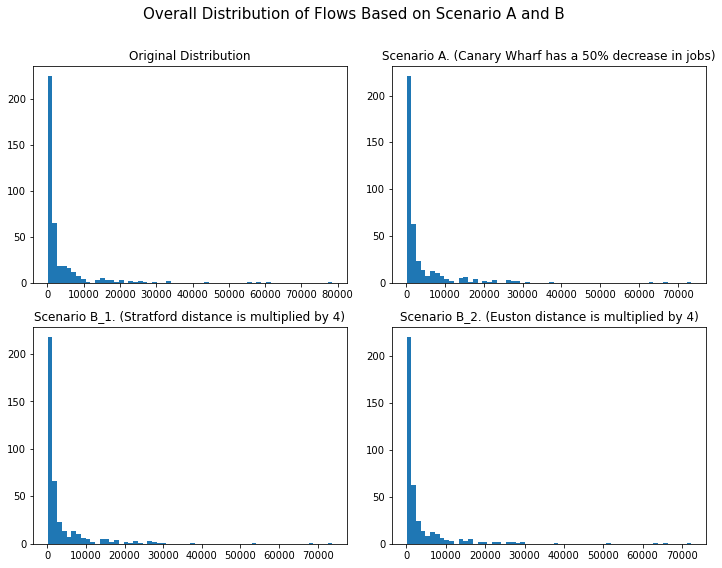

In [26]:
distribution_origin = cdatasubmat.loc['All']
distribution_origin = distribution_origin[:-1]

distribution_scenario_A = cdatasubmat1.loc['All']
distribution_scenario_A = distribution_scenario_A[:-1]

distribution_scenario_B_1 = cdatasubmat2.loc['All']
distribution_scenario_B_1 = distribution_scenario_B_1[:-1]

distribution_scenario_B_2 = cdatasubmat3.loc['All']
distribution_scenario_B_2 = distribution_scenario_B_2[:-1]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle('Overall Distribution of Flows Based on Scenario A and B \n', fontsize=15)
ax[0, 0].hist(distribution_origin, bins=60)
ax[0, 0].title.set_text('Original Distribution')
ax[0, 1].hist(distribution_scenario_A, bins=60)
ax[0, 1].title.set_text('Scenario A. (Canary Wharf has a 50% decrease in jobs)')
ax[1, 0].hist(distribution_scenario_B_1, bins=60)
ax[1, 0].title.set_text('Scenario B_1. (Stratford distance is multiplied by 4)')
ax[1, 1].hist(distribution_scenario_B_2, bins=60)
ax[1, 1].title.set_text('Scenario B_2. (Euston distance is multiplied by 4)')
plt.tight_layout()

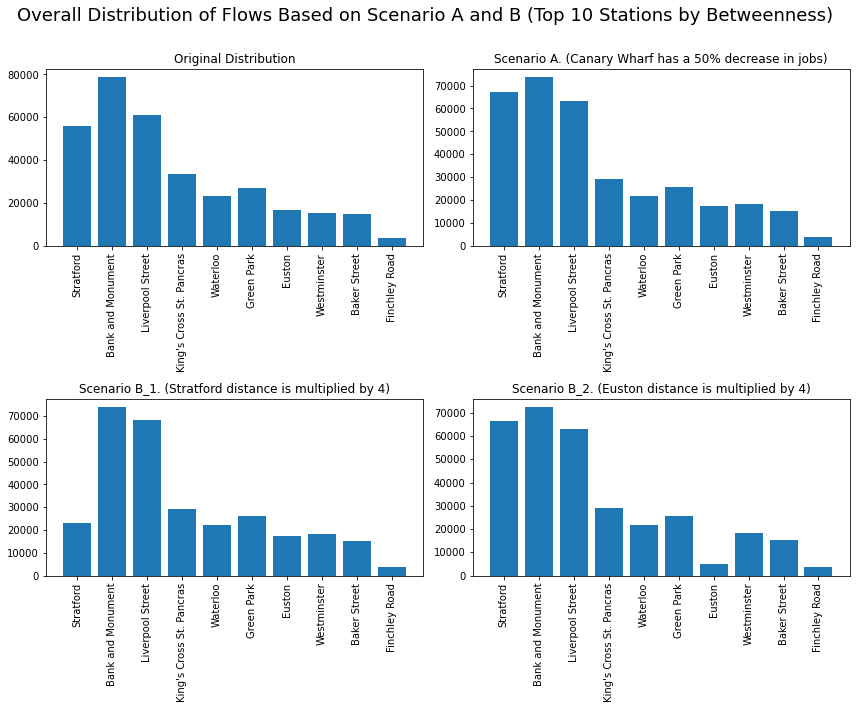

In [29]:
top10_betwenness = ['Stratford', 'Bank and Monument', 'Liverpool Street', 'King\'s Cross St. Pancras', 'Waterloo', 
                    'Green Park', 'Euston', 'Westminster', 'Baker Street', 'Finchley Road']
dist_origin = cdatasubmat[top10_betwenness]
dist_origin = dist_origin.loc['All']

dist_scenario_A = cdatasubmat1[top10_betwenness]
dist_scenario_A = dist_scenario_A.loc['All']

dist_scenario_B_1 = cdatasubmat2[top10_betwenness]
dist_scenario_B_1 = dist_scenario_B_1.loc['All']

dist_scenario_B_2 = cdatasubmat3[top10_betwenness]
dist_scenario_B_2 = dist_scenario_B_2.loc['All']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Overall Distribution of Flows Based on Scenario A and B (Top 10 Stations by Betweenness) \n', fontsize=18)
ax[0, 0].bar(top10_betwenness, dist_origin)
ax[0, 0].xaxis.set_ticks(top10_betwenness)
ax[0, 0].set_xticklabels(top10_betwenness, rotation=90)
ax[0, 0].title.set_text('Original Distribution')

ax[0, 1].bar(top10_betwenness, dist_scenario_A)
ax[0, 1].xaxis.set_ticks(top10_betwenness)
ax[0, 1].set_xticklabels(top10_betwenness, rotation=90)
ax[0, 1].title.set_text('Scenario A. (Canary Wharf has a 50% decrease in jobs)')

ax[1, 0].bar(top10_betwenness, dist_scenario_B_1)
ax[1, 0].xaxis.set_ticks(top10_betwenness)
ax[1, 0].set_xticklabels(top10_betwenness, rotation=90)
ax[1, 0].title.set_text('Scenario B_1. (Stratford distance is multiplied by 4)')

ax[1, 1].bar(top10_betwenness, dist_scenario_B_2)
ax[1, 1].xaxis.set_ticks(top10_betwenness)
ax[1, 1].set_xticklabels(top10_betwenness, rotation=90)
ax[1, 1].title.set_text('Scenario B_2. (Euston distance is multiplied by 4)')

plt.tight_layout()